In [55]:
# Download the dataset
!wget http://www.eyrignoux.com.fr/coursIA/deepLearning/terrakhod-20181124.zip

--2018-12-07 07:31:51--  http://www.eyrignoux.com.fr/coursIA/deepLearning/terrakhod-20181124.zip
Résolution de www.eyrignoux.com.fr (www.eyrignoux.com.fr)… 62.210.16.62
Connexion à www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 27361702 (26M) [application/zip]
Enregistre : «terrakhod-20181124.zip.1»

terrakhod-20181124. 100%[===================>]  26,09M  3,86MB/s    ds 6,8s    

2018-12-07 07:31:58 (3,85 MB/s) - «terrakhod-20181124.zip.1» enregistré [27361702/27361702]



In [57]:
#!unzip self-driving-toy-car.zip 
!unzip terrakhod-20181124.zip

Archive:  terrakhod-20181124.zip
replace terrakhod-20181124/3/frame_913_gas_0.0_dir_1.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [58]:
PATH = 'terrakhod-20181124/1/'

In [59]:

import numpy as np

def steering_encoder(steering_str):
    '''
    Converts the steering with appears in the file names to [0,0,1] (left),
    [0,1,0] (straight), or [1,0,0] (right)
    '''
    steering_float = float(steering_str)
    if steering_float == 0:
        return [0,1,0]
    elif steering_float < 0:
        return [0,0,1]
    else:
        return [1,0,0]



In [60]:

import re

def filename_decoder(file_name):
    '''exemple: frame_390_gas_-0.82_dir_-1.0.jpg
    '''
    gas, steering_str = re.search(r'_gas_(.+?)_dir_(.+?)\.jpg', file_name).groups()
    steering = steering_encoder(steering_str)
    return gas, steering


In [61]:

from os import listdir
from os.path import isfile, join

def list_files_in_dir(my_path):
    files = [f for f in listdir(my_path) if isfile(join(my_path, f))]
    return files

files = list_files_in_dir(PATH )

In [62]:

import skimage
from skimage.io import imread, imshow

def read_image_and_steering(file_name):

    image = skimage.io.imread(PATH + file_name)
    gas, steer = filename_decoder(file_name)
    return image, steer 


In [63]:

import cv2

def label_decoder_int(steering):
    '''Convert label from array to integer.
    
    '''
    if np.array_equal(steering, [1,0,0]):
        return -1
    elif np.array_equal(steering, [0,1,0]):
        return 0
    elif np.array_equal(steering, [0,0,1]):
        return 1
    else:
        print('Error: Label not recognized.')
        return
    
def draw_steer(image, steer, color):
    center = (image.shape[1]//2, image.shape[0]//2)
    offset = (image.shape[1]//2 + int(-label_decoder_int(steer)*image.shape[1]/2), image.shape[0]//2)
    
    img = image.copy()
    cv2.arrowedLine(img, center, offset, color=color, thickness=1, tipLength=0.4)      
    
    return img

frame_3412_gas_0.0_dir_-1.0.jpg
[0, 0, 1]


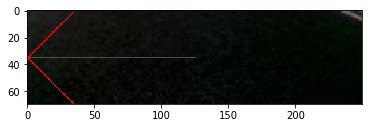

In [64]:
import random
import matplotlib.pyplot as plt

file_test = random.choice(files)
print(file_test)
img_test, steer_test = read_image_and_steering(file_test)

print(steer_test)
img_test_with_steer = draw_steer(img_test, steer_test, (255, 0, 0))
plt.imshow(img_test_with_steer)

##Augment the dataset
As usual, we add random transformations to the images, so that the neural network would learn to drive in different conditions: dark, light, shadows...

In [23]:

def horizontal_flip(img, steer):
    """Horizontal image flipping and angle correction.
    Img: Input image to transform in Numpy array.
    Angle: Corresponding label. Must be a 5-elements Numpy Array.
    """    
    return np.fliplr(img), np.flipud(steer)


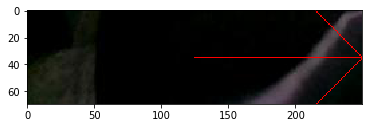

In [24]:
img_test_flip, steer_test_flip = horizontal_flip(img_test, steer_test)
img_test_flip_with_steer = draw_steer(img_test_flip, steer_test_flip, (255, 0, 0))
plt.imshow(img_test_flip_with_steer)

In [25]:

def augment_brightness_camera_images(image):
    '''Random bright augmentation (both darker and brighter).
    
    Returns:
    Transformed image and label.
    '''
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

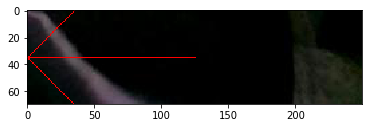

In [26]:
img_test_bright = augment_brightness_camera_images(img_test)
img_test_bright_with_steer = draw_steer(img_test_bright, steer_test, (255, 0, 0))
plt.imshow(img_test_bright_with_steer)

In [27]:

def add_random_shadow(image):
    '''Add random dark shadows to a given image.
    Returns:
    Transformed image and label.
    '''
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


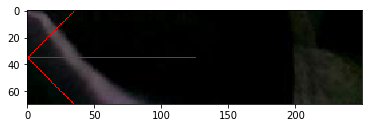

In [28]:
img_test_shadow = add_random_shadow(img_test)
img_test_shadow_with_steer = draw_steer(img_test_shadow, steer_test, (255, 0, 0))
plt.imshow(img_test_shadow_with_steer)

In [29]:

import skimage.exposure as exposure

def night_effect(img, vmin=185, vmax=195):
    """Change road color to black simulating night road.
    Returns
    Transformed image and label.
    """
    limit = random.uniform(vmin,vmax)
    low_limit = 146 
    int_img = exposure.rescale_intensity(img, in_range=(low_limit,limit), out_range='dtype')
    
    return int_img

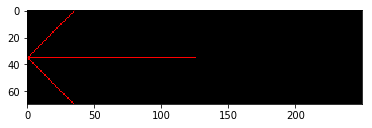

In [30]:

img_test_night = night_effect(img_test)
img_test_night_with_steer = draw_steer(img_test_night, steer_test, (255, 0, 0))
plt.imshow(img_test_night_with_steer)

In [31]:

def adjust_gamma_dark(image, min_=0.7, max_=0.8):
    '''Gamma correction to generate darker images.
    Image: Image in Numpy format (90,250,3)
    Label: Corresponding label of the image.
    Min: Minimum gamma value (the lower the darker)
    Max: Maximum gamma value (the higher the brigther) 
    Return:
    Transformed image and label.
    '''
    # build a lookup table mapping the pixel values [0, 255] to
    gamma = random.uniform(min_,max_)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


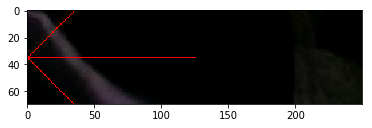

In [32]:

img_test_dark = adjust_gamma_dark(img_test)
img_test_dark_with_steer = draw_steer(img_test_dark, steer_test, (255, 0, 0))
plt.imshow(img_test_dark_with_steer)

In [33]:

def augment(image, steer):
    
    if np.random.random() > 0.75:
        image = adjust_gamma_dark(image)
    elif np.random.random() > 0.75:
        image = night_effect(image)
    elif np.random.random() > 0.75:
        image = add_random_shadow(image)
    elif np.random.random() > 0.75:
        image = augment_brightness_camera_images(image)
    elif np.random.random() > 0.75:
        image = augment_brightness_camera_images(image)
        image =  add_random_shadow(image)
        image, steer = horizontal_flip(image, steer)
                
    return image, steer

[0, 0, 1]


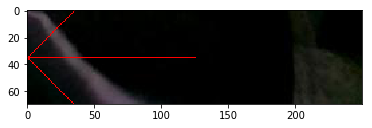

In [34]:
img_test_augmented, steer_augmented = augment(img_test, steer_test)
print(steer_augmented)
img_test_augmented_with_steer = draw_steer(img_test_augmented, steer_augmented, (255, 0, 0))
plt.imshow(img_test_augmented_with_steer)

##Create a generator for Keras

In [41]:

from itertools import chain
from itertools import islice

def batch_generator(file_names, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    
    ### YOUR CODE HERE
    # https://stackoverflow.com/questions/24527006/split-a-generator-into-chunks-without-pre-walking-it
    iterator = iter(file_names)
    for first in iterator:        
        yield list(chain([first], islice(iterator, batch_size - 1)))


In [42]:

def normalize(image):
    '''Return image centered around 0 with +- 0.5.
    image: Image to transform in Numpy array.
    '''
    return image/255.-.5

In [43]:

def train_generator(file_names, batch_size, shuffle = True, jitter = True, norm=True):
  
    if shuffle: np.random.shuffle(file_names)
      
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(file_names, batch_size):
          
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for file_name in batch:
              
                image, steer = read_image_and_steering(file_name)
                
                if jitter: image, steer = augment(image, steer)
                if norm:   image = normalize(image)
                  
                batch_imgs.append(image)
                batch_targets.append(steer)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = np.stack(batch_targets, axis=0)
            yield batch_imgs, batch_targets


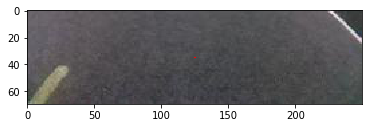

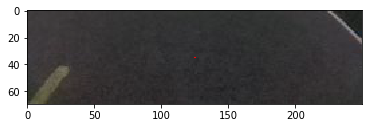

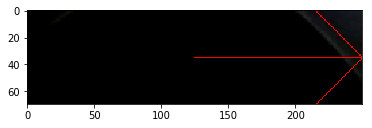

In [44]:

# test training generator
NB_IMGS_TEST = 3

img_numbers = random.sample(files, NB_IMGS_TEST)
for imgs, steers in train_generator(img_numbers, NB_IMGS_TEST, norm=False):
    for img, steer in zip(imgs, steers):
      img = draw_steer(img, steer, (255, 0, 0))
      plt.imshow(img)
      plt.show()
    break

# Construct the neural network
The proposed architecture is a slightly modified version of the PilotNet published by [Nvidia](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf). This architecture is powerful to modelize all possible driving situations while simple enough to run on the raspberry pi 3 B+. Dropout of 10% was added on two classifier layers to avoid overfitting.

In [45]:

IMG_SIZE = read_image_and_steering(files[0])[0].shape
IMG_SIZE

(70, 250, 3)

In [49]:

from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.models import Model

def model_categorical(input_size= IMG_SIZE, dropout=0.1):
    '''Generate an NVIDIA AutoPilot architecture.
    Input_size: Image shape (90, 250, 3), adjust to your desired input.
    Dropout: Proportion of dropout used to avoid model overfitting.
    This model ONLY predicts steering angle as a 5-elements array encoded with a Softmax output.
    The model is already compiled and ready to be trained.
    '''

    
    img_in = Input(shape=input_size, name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = Convolution2D(nb_filter=24, nb_row=5, nb_col=5, subsample=(2,2), activation='relu')(img_in)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(nb_filter=32, nb_row=5, nb_col=5, subsample=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(nb_filter=64, nb_row=5, nb_col=5, subsample=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(nb_filter=64, nb_row=3, nb_col=3, subsample=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(nb_filter=64, nb_row=3, nb_col=3, subsample=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(dropout)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(dropout)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    
    #categorical output of the angle
    angle_out = Dense(3, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    model = Model(input=[img_in], output=[angle_out])
    
    return model
  
model = model_categorical()

In [50]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 70, 250, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 33, 123, 24)   1824        img_in[0][0]                     
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 15, 60, 32)    19232       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 6, 28, 64)     51264       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [51]:

from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=5, mode='auto', verbose=1)
checkpoint  = ModelCheckpoint('ironcar_weights_keras12.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)


In [52]:

from sklearn.model_selection import train_test_split

# batch generator
BATCH_SIZE = 32
#BATCH_SIZE = 16

files_train, files_test = train_test_split(files, test_size=0.15)

#num_train = len(imgs_num_train)//BATCH_SIZE
#num_valid = len(imgs_num_test)//BATCH_SIZE
num_train = len(files_train)
num_valid = len(files_test)


In [53]:

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.fit_generator(generator = train_generator(files_train, BATCH_SIZE),
                    samples_per_epoch = num_train, 
                    nb_epoch  = 6, 
                    verbose = 1,
                    validation_data = train_generator(files_test, BATCH_SIZE, jitter = False), 
                    nb_val_samples = num_valid, 
                    callbacks = [early_stop, checkpoint])



Epoch 1/6
2323/2323 [==============================] - 14s - loss: 1.0024 - acc: 0.5510 - val_loss: 0.9408 - val_acc: 0.5523
Epoch 2/6
2323/2323 [==============================] - 14s - loss: 0.9722 - acc: 0.5588 - val_loss: 0.9424 - val_acc: 0.5523
Epoch 3/6
2323/2323 [==============================] - 14s - loss: 0.9675 - acc: 0.5609 - val_loss: 0.9244 - val_acc: 0.5718
Epoch 4/6
2323/2323 [==============================] - 14s - loss: 0.9699 - acc: 0.5652 - val_loss: 0.9179 - val_acc: 0.5766
Epoch 5/6
2323/2323 [==============================] - 14s - loss: 0.9444 - acc: 0.5730 - val_loss: 0.9072 - val_acc: 0.5742
Epoch 6/6
2323/2323 [==============================] - 15s - loss: 0.9546 - acc: 0.5743 - val_loss: 0.9210 - val_acc: 0.5742


# Check the predictions of the steering angle

[0, 0, 1]
[[ 0.26860359  0.57165504  0.15974137]]


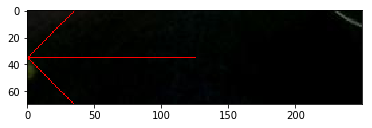

In [54]:

img_test, steer_test = read_image_and_steering(random.choice(files))

print(steer_test)
img_test = draw_steer(img_test, steer_test, (255, 0, 0))
plt.imshow(img_test)

steer_pred = model.predict(np.expand_dims(normalize(img_test), axis=0))
print(steer_pred)
    